3 algos:
- fmin_l_bfgs_b with FFT: shift but no dilation; known to work
- fmin_l_bfgs_b with interpolation: shift but no dilation in apply_delay function; supposed to work but unuseful
- fmin_l_bfgs_b with interpolation: shift and dilation; doesn't work for now; should change the constant and see if it works

Comparison in terms of Amari distance, time, shift and dilation error. 

Try to compute the gradient of the partial loss with respect to a and b, and see if it helps computing the constant automatically.

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from matplotlib.patches import Polygon
from time import time

import scipy
from scipy.optimize import fmin_l_bfgs_b
from sklearn.utils import check_random_state

import jax
import jax.numpy as jnp

from picard import amari_distance

from multiviewica_delay import _apply_continuous_delays

# parameters

In [2]:
# params
m = 5
p = 2
n = 600
nb_intervals = 5
nb_freqs = 10
threshold = 0.1
cste = 1e3  # XXX
max_dilation = 1.05 * cste  # XXX
max_shift = 20
max_delay = (np.ceil((n + max_shift) * max_dilation / cste) - n).astype("int")  # XXX
t0 = 0
noise_data = 0.05  # 0.1
noise_model = 1

# apply_delay functions

In [3]:
def apply_both_delays_1d_cyclic(s, a=1, b=0, t0=0):
    n = len(s)
    s_concat = jnp.concatenate([s[n-max_delay:], s, s[:max_delay]])
    t_concat = jnp.arange(len(s_concat)) - max_delay - t0
    t = jnp.arange(len(s)) - t0
    t_ab = (t - b) * a / cste  # XXX
    s_ab = jnp.interp(x=t_ab, xp=t_concat, fp=s_concat)
    return s_ab

def apply_both_delays_2d_cyclic(S, a=None, b=None, t0=0):
    p, n = S.shape
    if a is None:
        a = jnp.ones(p)
    if b is None:
        b = jnp.zeros(p)
        
    S_concat = jnp.concatenate([S[:, n-max_delay:], S, S[:, :max_delay]], axis=1)
    t_concat = jnp.arange(S_concat.shape[1]) - max_delay - t0

    t = jnp.arange(n) - t0
    T = jnp.array([t] * p)
    T_ab = ((T.T - b) * a / cste).T  # XXX
    S_ab = jnp.array(
        [jnp.interp(x=T_ab[i], xp=t_concat, fp=S_concat[i], left=0, right=0)
         for i in range(p)])
    return S_ab

def apply_both_delays_3d_cyclic(S_list, A=None, B=None, t0=0):
    Y_list = jnp.array([apply_both_delays_2d_cyclic(S_list[i], a=A[i], b=B[i], t0=t0) for i in range(len(S_list))])
    return Y_list

In [4]:
# used in fmin_l_bfgs_b with interpolation but no dilation
def apply_shift_1d(s, b=0):
    t = jnp.arange(len(s))
    t_b = t - b
    s_b = jnp.interp(x=t_b, xp=t, fp=s, left=0, right=0)
    return s_b

def apply_shifts_2d(S, b=None):
    p, n = S.shape
    if b is None:
        b = jnp.zeros(p)
    t = jnp.arange(n)
    T = jnp.array([t] * p)
    T_b = (T.T - b).T
    S_b = jnp.array(
        [jnp.interp(x=T_b[i], xp=t, fp=S[i], left=0, right=0)
         for i in range(p)])
    return S_b

def apply_shifts_3d(S_list, B=None):
    Y_list = jnp.array(
        [apply_shifts_2d(S_list[i], b=B[i])
         for i in range(len(S_list))])
    return Y_list

# find order function

In [5]:
def find_order(S1, S2):
    S1 = S1 / np.linalg.norm(S1, axis=1, keepdims=True)
    S2 = S2 / np.linalg.norm(S2, axis=1, keepdims=True)
    M = np.abs(np.dot(S1, S2.T))
    try:
        _, order = scipy.optimize.linear_sum_assignment(-abs(M))
    except ValueError:
        order = np.arange(p)
    return order

# generate data

In [6]:
def soft_threshold(S, threshold=0.1):
    return np.sign(S) * np.maximum(0, np.abs(S) - threshold)

def generate_source_one_interval(interval_length, freqs):
    t = np.linspace(0, 6 * np.pi, interval_length)
    s = np.sum([np.sin(f * t) for f in freqs], axis=0) / len(freqs)
    return s

def generate_one_source(interval_length, freqs, power):
    s = np.array(
        [p * generate_source_one_interval(interval_length, freqs[i, :])
         for p, i in zip(power, range(len(power)))]).reshape(-1)
    return s

def generate_sources(p, n, nb_intervals=5, nb_freqs=20, rng=None):
    if rng is None:
        rng = check_random_state(0)
    interval_length = n // nb_intervals
    freqs = rng.randn(p, nb_intervals, nb_freqs)
    power = rng.exponential(size=(p, nb_intervals))
    S = np.array([generate_one_source(interval_length, freqs[i], power[i]) for i in range(p)])
    shifts = (rng.rand(p) * n).astype("int")
    S = np.array([np.roll(S[i], shift) for i, shift in enumerate(shifts)])
    return S

def gen_data(
    m,
    p,
    n,
    nb_intervals=5,
    nb_freqs=20,
    threshold=0.1,
    max_dilation=1.1,
    max_shift=20,
    t0=0,
    noise_data=0.1,
    rng=None,
):
    if rng is None:
        rng = check_random_state(0)
    S = generate_sources(p, n, nb_intervals, nb_freqs, rng)
    S = soft_threshold(S, threshold=threshold)
    A_list = rng.randn(m, p, p)
    noise_list = noise_data * rng.randn(m, p, n)
    S_list = np.array([S + N for N in noise_list])
    # add delays
    dilations = rng.uniform(low=1/max_dilation*cste**2, high=max_dilation, size=(m, p))  # XXX
    shifts = rng.uniform(low=-max_shift, high=max_shift, size=(m, p))
    S_list = apply_both_delays_3d_cyclic(S_list, A=dilations, B=shifts, t0=t0)
    X_list = np.array([np.dot(A, S) for A, S in zip(A_list, S_list)])
    return X_list, A_list, dilations, shifts, S_list, S

# loss function with FFT and no dilation

In [7]:
def _logcosh(X):
    Y = jnp.abs(X)
    return Y + jnp.log1p(jnp.exp(-2 * Y))

def loss_function_fft(W_delays, X_list, noise_model=1):
    m, p, _ = X_list.shape
    W_list, delays = W_delays[:m*p**2].reshape((m, p, p)), W_delays[m*p**2:].reshape((m, p))
    S_list = jnp.array([jnp.dot(W, X) for W, X in zip(W_list, X_list)])
    Y_list = _apply_continuous_delays(
        S_list=S_list,
        tau_list=-delays,
        shared_delays=False,
        multiple_subjects=True,
        use_jax=True,
    )
    Y_avg = jnp.mean(Y_list, axis=0)
    loss = jnp.mean(_logcosh(Y_avg)) * p
    for W, Y in zip(W_list, Y_list):
        loss -= jnp.linalg.slogdet(W)[1]
        loss += 1 / (2 * noise_model) * jnp.mean((Y - Y_avg) ** 2) * p
    return loss

In [8]:
val_and_grad_fft = jax.jit(jax.value_and_grad(loss_function_fft))

def wrapper_loss_and_grad_fft(W_delays, X_list, noise_model):
    loss, grad = val_and_grad_fft(W_delays, X_list, noise_model)
    return loss, np.array(grad)

# loss function with interpolation but no dilation

In [9]:
def loss_function_interp_shift(W_delays, X_list, noise_model=1):
    m, p, _ = X_list.shape
    W_list, shifts = W_delays[:m*p**2].reshape((m, p, p)), W_delays[m*p**2:].reshape((m, p))
    S_list = jnp.array([jnp.dot(W, X) for W, X in zip(W_list, X_list)])
    Y_list = apply_shifts_3d(S_list, B=-shifts)
    Y_avg = jnp.mean(Y_list, axis=0)
    loss = jnp.mean(_logcosh(Y_avg)) * p
    for W, Y in zip(W_list, Y_list):
        loss -= jnp.linalg.slogdet(W)[1]
        loss += 1 / (2 * noise_model) * jnp.mean((Y - Y_avg) ** 2) * p
    return loss

In [10]:
val_and_grad_interp_shift = jax.jit(jax.value_and_grad(loss_function_interp_shift))

def wrapper_loss_and_grad_interp_shift(W_delays, X_list, noise_model):
    loss, grad = val_and_grad_interp_shift(W_delays, X_list, noise_model)
    return loss, np.array(grad)

# loss function with interpolation and dilation

In [11]:
def loss_function_interp(W_list, dilations, shifts, X_list, noise_model=1, t0=0):
    _, p, _ = X_list.shape
    S_list = jnp.array([jnp.dot(W, X) for W, X in zip(W_list, X_list)])
    Y_list = apply_both_delays_3d_cyclic(S_list, A=1/dilations, B=-shifts, t0=t0)
    Y_avg = jnp.mean(Y_list, axis=0)
    loss = jnp.mean(_logcosh(Y_avg)) * p
    for W, Y in zip(W_list, Y_list):
        loss -= jnp.linalg.slogdet(W)[1]
        loss += 1 / (2 * noise_model) * jnp.mean((Y - Y_avg) ** 2) * p
    return loss

def vector_to_parameters(W_delays, m, p):
    W_list = W_delays[:m*p**2].reshape((m, p, p))
    dilations = W_delays[m*p**2: m*p*(p+1)].reshape((m, p))
    shifts = W_delays[m*p*(p+1):].reshape((m, p))
    return W_list, dilations, shifts

def wrapped_loss_interp(W_delays, *args):
    return loss_function_interp(*vector_to_parameters(W_delays, m, p), *args)

In [12]:
val_and_grad_interp = jax.jit(jax.value_and_grad(wrapped_loss_interp))

def wrapper_loss_and_grad_interp(W_delays, X_list, noise_model, t0):
    loss, grad = val_and_grad_interp(W_delays, X_list, noise_model, t0)
    return loss, np.array(grad)

# first call: jit

In [13]:
random_state = 0
rng = check_random_state(random_state)
X_list, A_list, dilations, shifts, S_list, S = gen_data(
    m=m,
    p=p,
    n=n,
    nb_intervals=nb_intervals,
    nb_freqs=nb_freqs,
    threshold=threshold,
    max_dilation=max_dilation,
    max_shift=max_shift,
    t0=t0,
    noise_data=noise_data,
    rng=rng,
)

W_list_true = np.array([np.linalg.inv(A) for A in A_list])
W_list_init = W_list_true + 0.2 * rng.randn(m, p, p)
dilations_init = jnp.ones((m, p)) * cste  # XXX
shifts_init = jnp.zeros((m, p))

W_delays_fft = jnp.concatenate([jnp.ravel(W_list_init), jnp.ravel(shifts_init)])
W_delays_interp_shift = W_delays_fft
W_delays_interp = jnp.concatenate(
    [jnp.ravel(W_list_init), jnp.ravel(dilations_init), jnp.ravel(shifts_init)])

In [14]:
jax.config.update('jax_enable_x64', True)

In [15]:
start = time()
wrapper_loss_and_grad_fft(W_delays_fft, X_list, noise_model)
print(f"time : {time() - start}")

time : 3.939290761947632


In [16]:
start = time()
wrapper_loss_and_grad_interp_shift(W_delays_interp_shift, X_list, noise_model)
print(f"time : {time() - start}")

time : 7.19423770904541


In [17]:
start = time()
wrapper_loss_and_grad_interp(W_delays_interp, X_list, noise_model, t0)
print(f"time : {time() - start}")

time : 8.139307022094727


# callback

In [18]:
def amari_callable(W_delays, A_list):
    W_list = W_delays[:m*p**2].reshape((m, p, p))
    amari = np.mean([amari_distance(W, A) for W, A in zip(W_list, A_list)])
    return amari

class Amari_callback():
    def __init__(self, A_list):
        self.memory = []
        self.A_list = A_list
    
    def __call__(self, W_delays):
        self.memory.append(amari_callable(W_delays, self.A_list))

# run experiment function

In [19]:
def run_experiment(random_state):
    rng = check_random_state(random_state)
    # generate data
    X_list, A_list, dilations, shifts, S_list, S = gen_data(
        m=m,
        p=p,
        n=n,
        nb_intervals=nb_intervals,
        nb_freqs=nb_freqs,
        threshold=threshold,
        max_dilation=max_dilation,
        max_shift=max_shift,
        t0=t0,
        noise_data=noise_data,
        rng=rng,
    )
    # callback = Amari_callback(A_list)

    # initialization parameters
    W_list_true = np.array([np.linalg.inv(A) for A in A_list])
    W_list_init = W_list_true + 0.2 * rng.randn(m, p, p)
    dilations_init = jnp.ones((m, p)) * cste  # XXX
    shifts_init = jnp.zeros((m, p))
    W_delays_fft = jnp.concatenate([jnp.ravel(W_list_init), jnp.ravel(shifts_init)])
    W_delays_interp_shift = W_delays_fft
    W_delays_interp = jnp.concatenate(
        [jnp.ravel(W_list_init), jnp.ravel(dilations_init), jnp.ravel(shifts_init)])

    # bounds
    bounds_W = [(-jnp.inf, jnp.inf)] * (m * p ** 2)
    bounds_shifts = [(-max_shift, max_shift)] * (m * p)
    bounds_W_shifts = jnp.array(bounds_W + bounds_shifts)
    bounds_dilations = [(1/max_dilation*cste**2, max_dilation)] * (m * p)  # XXX
    bounds_W_dilations_shifts = jnp.array(bounds_W + bounds_dilations + bounds_shifts)

    # fmin_l_bfgs_b with FFT and no dilation
    start_fft = time()
    res_fft = fmin_l_bfgs_b(
        func=wrapper_loss_and_grad_fft,
        x0=W_delays_fft,
        args=(X_list, noise_model),
        bounds=bounds_W_shifts,
        # callback=callback,
        disp=False,
        factr=0,
        pgtol=1e-6,
    )
    time_fft = time() - start_fft

    # fmin_l_bfgs_b with interpolation but no dilation
    start_interp_shift = time()
    res_interp_shift = fmin_l_bfgs_b(
        func=wrapper_loss_and_grad_interp_shift,
        x0=W_delays_interp_shift,
        args=(X_list, noise_model),
        bounds=bounds_W_shifts,
        # callback=callback,
        disp=False,
        factr=0,
        pgtol=1e-6,
    )
    time_interp_shift = time() - start_interp_shift
    
    # fmin_l_bfgs_b with interpolation and dilation
    start_interp = time()
    res_interp = fmin_l_bfgs_b(
        func=wrapper_loss_and_grad_interp,
        x0=W_delays_interp,
        args=(X_list, noise_model, t0),
        bounds=bounds_W_dilations_shifts,
        # callback=callback,
        disp=False,
        factr=0,
        pgtol=1e-6,
    )
    time_interp = time() - start_interp
    
    # change results' shape
    W_delays_fft = res_fft[0]
    W_fft = W_delays_fft[:m*p**2].reshape((m, p, p))
    shifts_fft = W_delays_fft[m*p**2:].reshape((m, p))
    W_delays_interp_shift = res_interp_shift[0]
    W_interp_shift = W_delays_interp_shift[:m*p**2].reshape((m, p, p))
    shifts_interp_shift = W_delays_interp_shift[m*p**2:].reshape((m, p))
    W_delays_interp = res_interp[0]
    W_interp = W_delays_interp[:m*p**2].reshape((m, p, p))
    dilations_interp = W_delays_interp[m*p**2: m*p*(p+1)].reshape((m, p))
    shifts_interp = W_delays_interp[m*p*(p+1):].reshape((m, p))
    
    # Amari distance
    amari_fft = np.mean([amari_distance(W, A) for W, A in zip(W_fft, A_list)])
    amari_interp_shift = np.mean([amari_distance(W, A) for W, A in zip(W_interp_shift, A_list)])
    amari_interp = np.mean([amari_distance(W, A) for W, A in zip(W_interp, A_list)])
    W_random = rng.randn(m, p, p)
    amari_random = np.mean([amari_distance(W, A) for W, A in zip(W_random, A_list)])

    # compute average sources
    S_fft = np.mean([np.dot(W, X) for W, X in zip(W_fft, X_list)], axis=0)
    S_interp_shift = np.mean([np.dot(W, X) for W, X in zip(W_interp_shift, X_list)], axis=0)
    S_interp = np.mean([np.dot(W, X) for W, X in zip(W_interp, X_list)], axis=0)
    
    # order
    order_fft = find_order(S, S_fft)
    shifts_fft = shifts_fft[:, order_fft]
    order_interp_shift = find_order(S, S_interp_shift)
    shifts_interp_shift = shifts_interp_shift[:, order_interp_shift]
    order_interp = find_order(S, S_interp)
    dilations_interp = dilations_interp[:, order_interp]
    shifts_interp = shifts_interp[:, order_interp]
    
    # delay error
    shifts_error_fft = np.mean(np.abs(shifts_fft - shifts))
    shifts_error_interp_shift = np.mean(np.abs(shifts_interp_shift - shifts))
    shifts_error_interp = np.mean(np.abs(shifts_interp - shifts))
    dilations_error_interp = np.mean(np.abs(dilations_interp - dilations))

    nb_seeds_random = 10
    shifts_error_random = 0
    dilations_error_random = 0
    for _ in range(nb_seeds_random):
        shifts_random = rng.uniform(low=-max_shift, high=max_shift, size=np.shape(shifts))
        shifts_error_random += np.mean(np.abs(shifts_random - shifts))
        dilations_random = rng.uniform(low=1/max_dilation*cste**2, high=max_dilation, size=np.shape(dilations))  # XXX
        dilations_error_random += np.mean(np.abs(dilations_random - dilations))
    shifts_error_random /= nb_seeds_random
    dilations_error_random /= nb_seeds_random
    
    # result
    dict_res = {"amari_fft": [amari_fft],
                "amari_interp_shift": [amari_interp_shift],
                "amari_interp": [amari_interp],
                "amari_random": [amari_random],
                "time_fft": [time_fft],
                "time_interp_shift": [time_interp_shift],
                "time_interp": [time_interp],
                "shifts_error_fft": [shifts_error_fft],
                "shifts_error_interp_shift": [shifts_error_interp_shift],
                "shifts_error_interp": [shifts_error_interp],
                "dilations_error_interp": [dilations_error_interp],
                "shifts_error_random": [shifts_error_random],
                "dilations_error_random": [dilations_error_random]}
    return dict_res

# multiple seeds

In [20]:
# ~10sec per seed
cste = 1e3
max_dilation = 1.1 * cste
nb_seeds = 30
df_res = pd.DataFrame()
for random_state in range(nb_seeds):
    dict_expe = run_experiment(random_state)
    df_expe = pd.DataFrame(dict_expe)
    df_res = pd.concat([df_res, df_expe], ignore_index=True)

/tmp/ipykernel_34085/1469475027.py:2: RuntimeWarning: invalid value encountered in true_divide
  S1 = S1 / np.linalg.norm(S1, axis=1, keepdims=True)


In [21]:
df_res

,amari_fft,amari_interp_shift,amari_interp,amari_random,time_fft,time_interp_shift,time_interp,shifts_error_fft,shifts_error_interp_shift,shifts_error_interp,dilations_error_interp,shifts_error_random,dilations_error_random
0,0.175531,0.195324,0.117289,0.279548,4.028263,7.266091,15.196973,8.665678,10.174547,18.315926,118.703244,12.973369,58.815537
1,0.106092,0.083366,0.062741,0.239524,1.906664,8.773493,1.409291,11.884407,8.003946,18.346949,73.921817,12.216957,57.707855
2,0.004671,0.018595,0.328458,0.219689,0.190530,0.744774,14.764388,14.218930,12.150520,16.858020,80.267142,15.914407,72.382530
3,0.008899,0.016072,0.072633,0.365127,0.469796,0.508066,14.747538,12.558429,9.194052,18.375874,71.050885,15.182625,64.757103
4,0.018724,0.017200,0.111888,0.239239,0.418150,0.309830,14.712856,5.020956,3.616505,21.182328,117.302196,13.404887,70.129716
5,0.001479,0.005047,0.205207,0.316662,0.174043,0.092093,5.416222,13.232524,11.409669,20.263133,80.400352,13.674678,67.817912
6,0.056859,0.160346,0.214601,0.323127,0.244198,0.968121,12.197549,11.511983,10.286283,17.068331,94.554119,12.045567,68.430617
7,0.021277,0.162592,0.511133,0.225936,0.209466,0.637855,14.837311,10.746619,9.039232,18.703508,84.781336,12.138902,57.955784
8,0.050975,0.089683,0.319872,0.151453,0.955807,1.022014,3.458972,15.445552,15.232466,24.523222,99.579799,14.693265,70.133397
9,0.008418,0.071900,0.238529,0.296322,0.484190,0.281839,0.686432,12.340077,9.041023,20.644858,72.551799,12.911076,64.650832


Why is the Amari distance higher for amari_interp_shift than for amari_fft? Indeed, those 2 methods don't estimate dilations, so they should perform similarly. This gap can't be due to a bad stepsize (bad constant choice) for the shifts parameters, as a shift of 1 means the same for both methods. I really don't understand. 

In [22]:
mean_amari_random = np.mean(df_res['amari_random'])
mean_shifts_error_random = np.mean(df_res['shifts_error_random'])
mean_dilations_error_random = np.mean(df_res['dilations_error_random'])

# plot

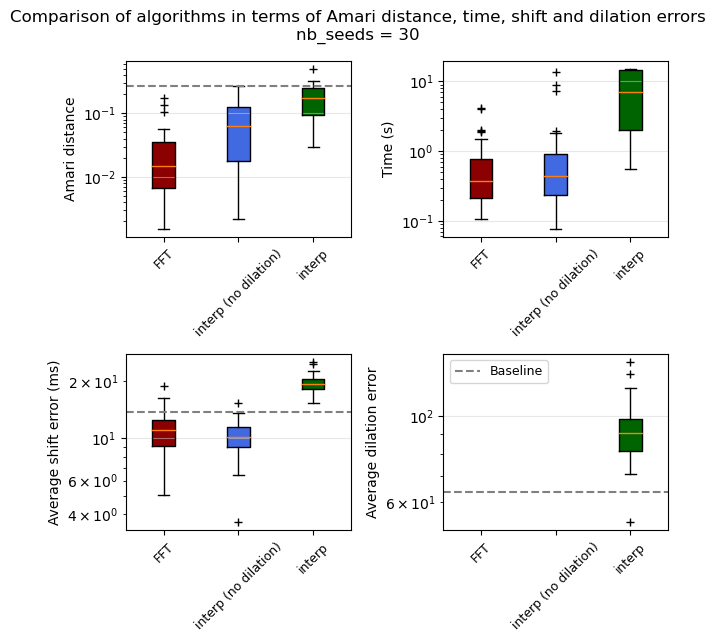

In [23]:
# plot
def one_subplot(data, ylabel, ax, logscale=False, average=None):
    bp = ax.boxplot(data)
    ax.set(ylabel=ylabel)
    ax.yaxis.grid(True, linestyle='-', which='major', color='lightgrey', alpha=0.5)
    plt.setp(bp['fliers'], color='red', marker='+')
    # box_colors = ['darkkhaki', 'royalblue', 'darkred']  # 'darkgreen', 'purple'
    box_colors = ['darkred', 'royalblue', 'darkgreen']
    nb_algos = len(data)
    for i in range(nb_algos):
        box = bp['boxes'][i]
        box_x = []
        box_y = []
        for j in range(5):
            box_x.append(box.get_xdata()[j])
            box_y.append(box.get_ydata()[j])
        box_coords = np.column_stack([box_x, box_y])
        ax.add_patch(Polygon(box_coords, facecolor=box_colors[i]))
    ax.set_xticklabels(
        ['FFT', 'interp (no dilation)', 'interp'],
        rotation=45, fontsize=9)
    if logscale is True:
        ax.set_yscale('log')
    if average is not None:
        ax.axhline(average, c='grey', linestyle='--')

fig, axs = plt.subplots(2, 2, figsize=(6.5, 6.5))

one_subplot(
    [df_res['amari_fft'], df_res['amari_interp_shift'], df_res['amari_interp']],
    'Amari distance', 
    axs[0, 0], 
    logscale=True,
    average=mean_amari_random)
one_subplot(
    [df_res['time_fft'], df_res['time_interp_shift'], df_res['time_interp']],
    'Time (s)',
    axs[0, 1],
    logscale=True)
one_subplot(
    [df_res['shifts_error_fft'], df_res['shifts_error_interp_shift'], df_res['shifts_error_interp']],
    'Average shift error (ms)',
    axs[1, 0],
    logscale=True,
    average=mean_shifts_error_random)
null = np.full(nb_seeds, np.nan)
one_subplot(
    [null, null, df_res['dilations_error_interp']],
    'Average dilation error',
    axs[1, 1],
    logscale=True,
    average=mean_dilations_error_random)

from matplotlib.lines import Line2D
plt.legend([Line2D([0], [0], linestyle='--', color='grey', lw=1.5)], ['Baseline'], fontsize=9)

plt.suptitle(f"Comparison of algorithms in terms of Amari distance, time, shift and dilation errors\nnb_seeds = {nb_seeds}")
plt.tight_layout()